In [1]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph
sns.set()
sns.set_style("whitegrid")


In [2]:
def law_2021_model():
    """Instantiate the beta modulated ERP network model.
    Returns
    -------
    net : Instance of Network object
        Network object used to store the model used in
        Law et al. 2021.
    See Also
    --------
    jones_2009_model
    Notes
    -----
    Model reproduces results from Law et al. 2021
    This model differs from the default network model in several
    parameters including
    1) Increased GABAb time constants on L2/L5 pyramidal cells
    2) Decrease L5_pyramidal -> L5_pyramidal nmda weight
    3) Modified L5_basket -> L5_pyramidal inhibition weights
    4) Removal of L5 pyramidal somatic and basal dendrite calcium channels
    5) Replace L2_basket -> L5_pyramidal GABAa connection with GABAb
    6) Addition of L5_basket -> L5_pyramidal distal connection
    """

    hnn_core_root = op.dirname(hnn_core.__file__)
    params_fname = op.join(hnn_core_root, 'param', 'default.json')
    params = read_params(params_fname)

    net = jones_2009_model(params)

    # Update biophysics (increase gabab duration of inhibition)
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau2'] = 200.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau2'] = 200.0

    # Decrease L5_pyramidal -> L5_pyramidal nmda weight
    net.connectivity[2]['nc_dict']['A_weight'] = 0.0004

    # Modify L5_basket -> L5_pyramidal inhibition
    net.connectivity[6]['nc_dict']['A_weight'] = 0.02  # gabaa
    net.connectivity[7]['nc_dict']['A_weight'] = 0.005  # gabab

    # Remove L5 pyramidal somatic and basal dendrite calcium channels
    for sec in ['soma', 'basal_1', 'basal_2', 'basal_3']:
        del net.cell_types['L5_pyramidal'].sections[
            sec].mechs['ca']

    # Remove L2_basket -> L5_pyramidal gabaa connection
    del net.connectivity[10]  # Original paper simply sets gbar to 0.0

    # Add L2_basket -> L5_pyramidal gabab connection
    delay = net.delay
    src_cell = 'L2_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 50.
    weight = 0.00005
    loc = 'distal'
    receptor = 'gabab'
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    # Add L5_basket -> L5_pyramidal distal connection
    # ("Martinotti-like recurrent tuft connection")
    src_cell = 'L5_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 70.
    loc = 'distal'
    receptor = 'gabaa'
    key = f'gbar_L5Basket_L5Pyr_{receptor}'
    weight = net._params[key]
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    return net

In [23]:
def add_law_beta_drives(net, beta_start, l2inh_prob=1.0, l5inh_prob=1.0):
    # Distal Drive
    weights_ampa_d1 = {'L2_basket': 0.00032 * 2.0, 'L2_pyramidal': 0.00008,
                       'L5_pyramidal': 0.00004}
    syn_delays_d1 = {'L2_basket': 0.5, 'L2_pyramidal': 0.5,
                     'L5_pyramidal': 0.5}
    net.add_bursty_drive(
        'Distal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=5., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='distal', weights_ampa=weights_ampa_d1,
        synaptic_delays=syn_delays_d1, event_seed=10)

    # Proximal Drive
    weights_ampa_p1 = {'L2_basket': 0.00004 * 2.0, 'L2_pyramidal': 0.00002,
                       'L5_basket': 0.00002, 'L5_pyramidal': 0.00002}
    syn_delays_p1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                     'L5_basket': 1.0, 'L5_pyramidal': 1.0}
    syn_delays_p1 = {'L2_basket': l2inh_prob, 'L2_pyramidal': l5inh_prob,
                     'L5_basket': 1.0, 'L5_pyramidal': 1.0}

    net.add_bursty_drive(
        'Proximal Drive', tstart=beta_start, tstart_std=0., tstop=beta_start + 50.,
        burst_rate=1., burst_std=30., numspikes=2, spike_isi=10, n_drive_cells=10,
        location='proximal', weights_ampa=weights_ampa_p1,
        synaptic_delays=syn_delays_p1, event_seed=10)

    return net

In [24]:
net_orig = law_2021_model()

l5_prob_sweep = [0.2, 0.5, 1.0]
dpl_L5IN_list = list()
net_L5IN_list = list()

for strength in l5_prob_sweep:

    net = net_orig.copy()
    add_law_beta_drives(net, beta_start=200.0, l5inh_prob=prob, l2inh_prob=1.0)

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

    dpl_L5IN_list.append(dpl)
    net_L5IN_list.append(net)

MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

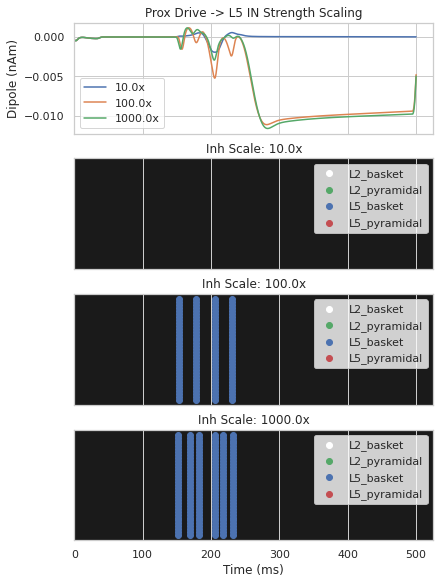

In [30]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, prob, net) in enumerate(zip(dpl_L5IN_list, l5_prob_sweep, net_L5IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{prob}x')
    axes[plot_idx+1].set_title(f'Connection Prob: {prob}x')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+1], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('Prox Drive -> L5 IN Prob Sweep')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
axes[0].legend()
plt.savefig('u19_page2_figures/law_input_prox_l5inh_prob_sweep_spikes.png')


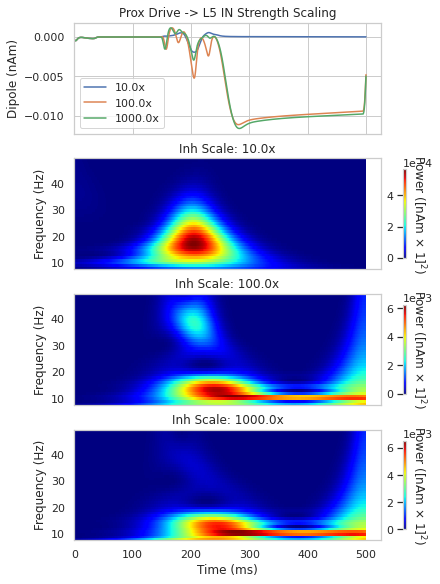

In [31]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L5IN_list[0].times
for plot_idx, (plt_dpl, prob) in enumerate(zip(dpl_L5IN_list, l5_prob_sweep)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{prob}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+1], show=False, colormap='jet')
    axes[plot_idx+1].set_title(f'Connectio Prob: {prob}x')

axes[0].set_title('Prox Drive -> L5 IN Prob Sweep')
axes[0].legend()
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.savefig('u19_page2_figures/law_input_prox_l5inh_prob_sweep_spectrogram.png')


In [15]:
net_orig = law_2021_model()

l2_prob_sweep = [0.2, 0.5, 1.0]
dpl_L2IN_list = list()
net_L2IN_list = list()

for strength in l2_prob_sweep:

    net = net_orig.copy()
    add_law_beta_drives(net, beta_start=200.0, l2inh_prob=prob)

    with MPIBackend(n_procs=8):
        dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

    dpl_L2IN_list.append(dpl)
    net_L2IN_list.append(net)


MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

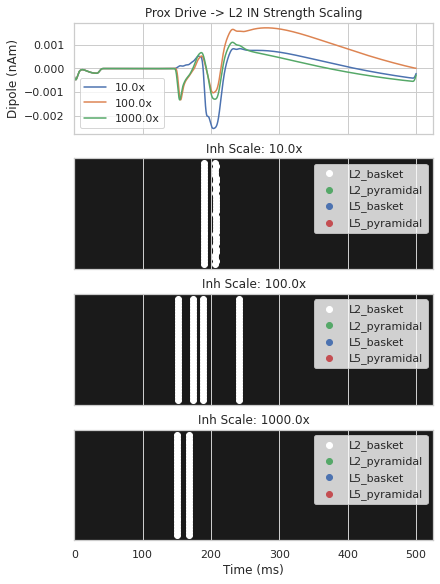

In [29]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, prob, net) in enumerate(zip(dpl_L2IN_list, l2_prob_sweep, net_L2IN_list)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{prob}x')
    axes[plot_idx+1].set_title(f'Connection Prob: {prob}x')
    net.copy().cell_response.plot_spikes_raster(ax=axes[plot_idx+1], show=False)
    axes[plot_idx].set_xlabel('')


axes[0].set_title('Prox Drive -> L2 IN Prob Sweep')
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
axes[0].legend()
plt.savefig('u19_page2_figures/law_input_prox_l2inh_prob_sweep_spikes.png')


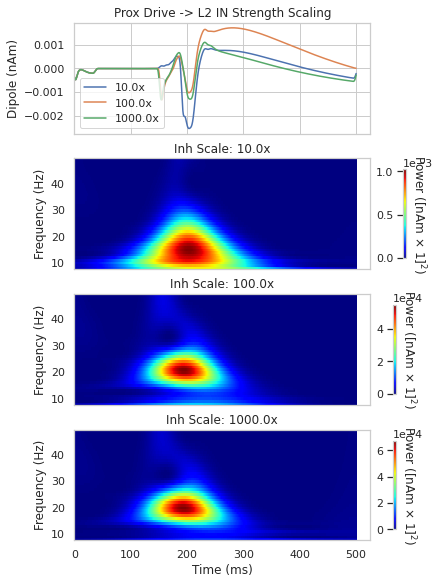

In [28]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8), constrained_layout=True)
freqs = np.arange(8, 50)
times = dpl_L2IN_list[0].times
for plot_idx, (plt_dpl, scale) in enumerate(zip(dpl_L2IN_list, l2_prob_sweep)):
    dpl_smooth = plt_dpl.copy().smooth(10).data['agg']
    axes[0].plot(times, dpl_smooth, label=f'{scale}x')
    axes[plot_idx].set_xlabel('')
    plt_dpl.copy().plot_tfr_morlet(freqs, ax=axes[plot_idx+1], show=False, colormap='jet')
    axes[plot_idx+1].set_title(f'Connection Prob: {scale}x')

axes[0].set_title('Prox Drive -> L2 IN Prob Sweep')
axes[0].legend()
axes[3].set_xlabel('Time (ms)')
axes[0].set_ylabel('Dipole (nAm)')
plt.savefig('u19_page2_figures/law_input_prox_l2inh_prob_sweep_spectrogram.png')
